In [1]:
from __future__ import print_function
import numpy as np
import scipy.io as sio
import pandas as pd
from sklearn.metrics import mean_squared_error

np.random.seed(1337)  # for reproducibility

# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [5]:
# input image dimensions
img_rows, img_cols = 128, 128
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# Training data, shuffled and split
WB = np.array(sio.loadmat('sandstone_data.mat')['Data'])
Y_data = np.array(sio.loadmat('sandstone_data.mat')['L'])
Y_data = (Y_data-min(Y_data))/(max(Y_data)-min(Y_data))
X_data = np.reshape(WB,(768,1,img_rows,img_cols))

# Add 380 generated images using VAE+ST from Ruijin's code
WB_gen = np.array(sio.loadmat('generate_sandstone_data.mat')['Data'])
Y_gen = np.array(sio.loadmat('generate_sandstone_data.mat')['L'])
Y_gen = (Y_gen-min(Y_gen))/(max(Y_gen)-min(Y_gen))
X_gen = np.transpose(np.reshape(WB_gen,(380,1,img_rows,img_cols)),[0,1,3,2])


#Define Traing data and validation data
X_train = np.concatenate((X_data[0:700], X_gen[0:150], X_gen[230:380]), axis=0);
Y_train = np.concatenate((Y_data[0:700], Y_gen[0:150], Y_gen[230:380]), axis=0);
X_val = np.concatenate((X_data[700:768], X_gen[150:230]), axis=0);
Y_val = np.concatenate((Y_data[700:768], Y_gen[150:230]), axis=0);

"""
X_train = X_data[:720]
Y_train = Y_data[:720]

X_val = X_data[720:]
Y_val = Y_data[720:]
"""

WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
Y_test = sio.loadmat('test_sandstone_data.mat')['L']
Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))


if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (1000, 128, 128, 1)
1000 train samples
148 validate samples
240 test samples


In [29]:
# CNN

model = Sequential()

model.add(Convolution2D(24, (6, 6), padding='same', input_shape=input_shape))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))


model.add(Convolution2D(48, (3, 3), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))


model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))


model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))



#Training result was worse with this layer...complex network led to overfitting...need to fine tune the framework
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))



model.add(AveragePooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
# model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('relu'))
# model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [30]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='min')
model.fit(X_train, Y_train, batch_size=40, epochs=120, verbose=1, validation_data=(X_val, Y_val))
          # callbacks=[early_stop], initial_epoch=0)

Train on 1000 samples, validate on 148 samples
Epoch 1/120
1000/1000 [==============================] - 32s - loss: 0.0831 - mean_absolute_error: 0.2141 - val_loss: 0.2195 - val_mean_absolute_error: 0.4175
Epoch 2/120
1000/1000 [==============================] - 32s - loss: 0.0337 - mean_absolute_error: 0.1461 - val_loss: 0.3092 - val_mean_absolute_error: 0.5129
Epoch 3/120
1000/1000 [==============================] - 33s - loss: 0.0233 - mean_absolute_error: 0.1198 - val_loss: 0.2739 - val_mean_absolute_error: 0.4765
Epoch 4/120
1000/1000 [==============================] - 33s - loss: 0.0194 - mean_absolute_error: 0.1090 - val_loss: 0.2299 - val_mean_absolute_error: 0.4285
Epoch 5/120
1000/1000 [==============================] - 35s - loss: 0.0172 - mean_absolute_error: 0.1034 - val_loss: 0.1248 - val_mean_absolute_error: 0.2804
Epoch 6/120
1000/1000 [==============================] - 32s - loss: 0.0185 - mean_absolute_error: 0.1072 - val_loss: 0.1644 - val_mean_absolute_error: 0.3402

1000/1000 [==============================] - 39s - loss: 0.0054 - mean_absolute_error: 0.0589 - val_loss: 0.0263 - val_mean_absolute_error: 0.1526
Epoch 52/120
1000/1000 [==============================] - 36s - loss: 0.0060 - mean_absolute_error: 0.0607 - val_loss: 0.0088 - val_mean_absolute_error: 0.0811
Epoch 53/120
1000/1000 [==============================] - 36s - loss: 0.0041 - mean_absolute_error: 0.0508 - val_loss: 0.0305 - val_mean_absolute_error: 0.1533
Epoch 54/120
1000/1000 [==============================] - 34s - loss: 0.0041 - mean_absolute_error: 0.0513 - val_loss: 0.0355 - val_mean_absolute_error: 0.1675
Epoch 55/120
1000/1000 [==============================] - 33s - loss: 0.0043 - mean_absolute_error: 0.0518 - val_loss: 0.0224 - val_mean_absolute_error: 0.1400
Epoch 56/120
1000/1000 [==============================] - 38s - loss: 0.0047 - mean_absolute_error: 0.0540 - val_loss: 0.0266 - val_mean_absolute_error: 0.1546
Epoch 57/120
1000/1000 [=============================

1000/1000 [==============================] - 32s - loss: 0.0025 - mean_absolute_error: 0.0390 - val_loss: 0.0159 - val_mean_absolute_error: 0.1064
Epoch 103/120
1000/1000 [==============================] - 33s - loss: 0.0019 - mean_absolute_error: 0.0343 - val_loss: 0.0244 - val_mean_absolute_error: 0.1466
Epoch 104/120
1000/1000 [==============================] - 33s - loss: 0.0023 - mean_absolute_error: 0.0385 - val_loss: 0.0097 - val_mean_absolute_error: 0.0891
Epoch 105/120
1000/1000 [==============================] - 36s - loss: 0.0022 - mean_absolute_error: 0.0373 - val_loss: 0.0366 - val_mean_absolute_error: 0.1714
Epoch 106/120
1000/1000 [==============================] - 32s - loss: 0.0027 - mean_absolute_error: 0.0411 - val_loss: 0.0092 - val_mean_absolute_error: 0.0859
Epoch 107/120
1000/1000 [==============================] - 37s - loss: 0.0023 - mean_absolute_error: 0.0370 - val_loss: 0.0155 - val_mean_absolute_error: 0.1115
Epoch 108/120
1000/1000 [=======================

training mse: 0.0027788477055
testing mse: 0.0183243095895


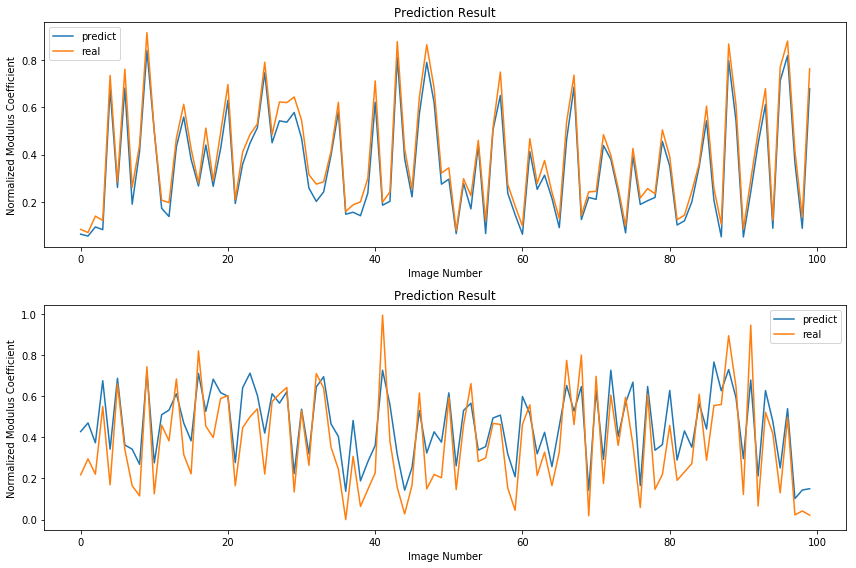

In [31]:
x=[]
for i in range(100):
    x.append(i)

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(2,1,1)

train_pred=model.predict(X_train)
print('training mse:', mean_squared_error(Y_train, train_pred))

ax1.plot(x,train_pred[0:100], label='predict')
ax1.plot(x,Y_train[0:100],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')


ax2=fig.add_subplot(2,1,2)

test_pred=model.predict(X_test)
print('testing mse:', mean_squared_error(Y_test, test_pred))

ax2.plot(x,test_pred[0:100], label='predict')
ax2.plot(x,Y_test[0:100],label='real')
plt.legend()
ax2.set_title('Prediction Result')
ax2.set_xlabel('Image Number')
ax2.set_ylabel('Normalized Modulus Coefficient')

plt.tight_layout()

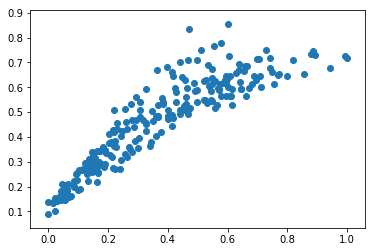

In [32]:
plt.scatter(Y_test.reshape(-1),test_pred)

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 128, 128, 24)      888       
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 24)      96        
_________________________________________________________________
activation_71 (Activation)   (None, 128, 128, 24)      0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 64, 64, 24)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 64, 64, 32)        6944      
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_72 (Activation)   (None, 64, 64, 32)        0         
__________